In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full-exper-LT.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,7"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.per_process_gpu_memory_fraction = 0.7
# configuration.gpu_options.visible_device_list = "1, 2"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

Using TensorFlow backend.


In [6]:
config_vars["root_directory"] = '/home/seizethedty/DATA/LineageTracking/'
experiment_name = '12'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [3]:
# config_vars["no_boundary_labels_dir"] = '/home/seizethedty/DATA/LineageTracking/no_boundary_labels/'
# os.makedirs(config_vars["no_boundary_labels_dir"], exist_ok=True)

In [7]:
config_vars

{'root_directory': '/home/seizethedty/DATA/LineageTracking/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/seizethedty/DATA/LineageTracking/raw_images/',
 'raw_annotations_dir': '/home/seizethedty/DATA/LineageTracking/raw_annotations/',
 'normalized_images_dir': '/home/seizethedty/DATA/LineageTracking/norm_images/',
 'boundary_labels_dir': '/home/seizethedty/DATA/LineageTracking/boundary_labels/',
 'experiment_dir': '/home/seizethedty/DATA/LineageTracking/experiments/12/

### PREPROCESS

<a list of 100 Patch objects>

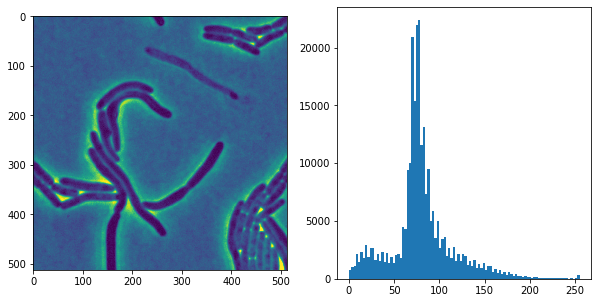

In [5]:
img = skimage.io.imread(config_vars["normalized_images_dir"] + '023/015.png')

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)[2]

--------------------------------

In [8]:
"""

'path_files_training': 'DATA/LinearTracking/training.txt',
'path_files_validation': 'DATA/LinearTracking/validation.txt',
'path_files_test': 'DATA/LinearTracking/test.txt',

folder 001 - 095 total 1585 images, 16.68 for one folder
setup dirs: `normalized` and `boundary label`
img list should contain file names like 001/0000.tif

"""  

#fd_list = sorted(os.listdir('~/DATA/LineageTracking/raw_images/'))
fd_list = sorted(os.listdir('/home/seizethedty/DATA/LineageTracking/raw_images'))
# makedirs for 001, 002, ...
for f in fd_list:
    os.makedirs(config_vars["normalized_images_dir"] + f, exist_ok=True)
    os.makedirs(config_vars["boundary_labels_dir"] + f, exist_ok=True)   

In [9]:
"""split train, valid, test (image name list)

"""
train_fd_list = fd_list[:62]
valid_fd_list = fd_list[62:]

# boundary_labels_gai是清洗过后的labels
list_train = []
for f in train_fd_list:
    tmp_list = os.listdir('/home/seizethedty/DATA/LineageTracking/boundary_labels/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    if f == '000':
        for e in sorted(tmp_list):
            list_train.append(f + '/' + e)
    else:
        for e in sorted(tmp_list)[:11]:
            list_train.append(f + '/' + e)
        
list_valid = []
for f in valid_fd_list:
    tmp_list = os.listdir('/home/seizethedty/DATA/LineageTracking/boundary_labels/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for e in sorted(tmp_list)[:]:
        list_valid.append(f + '/' + e)
        
list_test = []


utils.dirtools.write_path_files(config_vars["path_files_training"], list_train)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_valid)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

#list_train
valid_fd_list

['061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095']

In [10]:
# get these two lists for pre-process on all data
img_list = []
for f in fd_list:
    tmp_list = os.listdir('/home/seizethedty/DATA/LineageTracking/raw_images/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('tif')]
    for img in sorted(tmp_list):
        img_list.append(f + '/' + img)

mask_list = []
for f in fd_list:
    tmp_list = os.listdir('/home/seizethedty/DATA/LineageTracking/raw_annotations/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for mask in sorted(tmp_list):
        mask_list.append(f + '/' + mask)  

mask_list

['001/000.png',
 '001/001.png',
 '001/002.png',
 '001/003.png',
 '001/004.png',
 '001/005.png',
 '001/006.png',
 '001/007.png',
 '001/008.png',
 '001/009.png',
 '001/010.png',
 '001/011.png',
 '001/012.png',
 '001/013.png',
 '001/014.png',
 '001/015.png',
 '002/000.png',
 '002/001.png',
 '002/002.png',
 '002/003.png',
 '002/004.png',
 '002/005.png',
 '002/006.png',
 '002/007.png',
 '002/008.png',
 '002/009.png',
 '002/010.png',
 '002/011.png',
 '002/012.png',
 '002/013.png',
 '002/014.png',
 '002/015.png',
 '003/000.png',
 '003/001.png',
 '003/002.png',
 '003/003.png',
 '003/004.png',
 '003/005.png',
 '003/006.png',
 '003/007.png',
 '003/008.png',
 '003/009.png',
 '003/010.png',
 '003/011.png',
 '003/012.png',
 '003/013.png',
 '003/014.png',
 '003/015.png',
 '004/000.png',
 '004/001.png',
 '004/002.png',
 '004/003.png',
 '004/004.png',
 '004/005.png',
 '004/006.png',
 '004/007.png',
 '004/008.png',
 '004/009.png',
 '004/010.png',
 '004/011.png',
 '004/012.png',
 '004/013.png',
 '004/01

In [9]:
# # normalize images

# # filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
# filelist = img_list  # Lineage Tracking has second order directory

# def normalize_original_img(filelist):
#     for filename in tqdm(filelist):
#         # load image and its annotation
#         orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
#         # normalize to [0,1]
#         percentile = 99.9
#         high = np.percentile(orig_img, percentile)  # maximum for all image
#         low = np.percentile(orig_img, 100-percentile)

#         img = np.minimum(high, orig_img)
#         img = np.maximum(low, img)

#         # gives float64, thus cast to 8 bit later
#         img = (img - low) / (high - low) 
#         img = skimage.img_as_ubyte(img) 

#         skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    

# normalize_original_img(filelist)

In [10]:
# # segmentation to boundary

# # filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
# # filelist = [x for x in filelist if x.endswith('png')]
# filelist = mask_list

# def segment_to_label(filelist, total_objects = 0):
#     for filename in tqdm(filelist):
#         annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
#         annot = skimage.morphology.label(annot)
#         total_objects += len(np.unique(annot)) - 1
#         annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
#         # find boundaries
#         boundaries = skimage.segmentation.find_boundaries(annot)
#         for k in range(2, config_vars["boundary_size"], 2):
#             boundaries = skimage.morphology.binary_dilation(boundaries)

#         # 3-CHANNEL BINARY LABEL
#         # prepare buffer for binary label
#         label_binary = np.zeros((annot.shape + (3,))) 
#         label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
#         label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
#         label_binary[boundaries == 1, 2] = 1  # boundary
#         # Convert an image to unsigned byte format, with values in [0, 255]
#         label_binary = skimage.img_as_ubyte(label_binary)
#         skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
#     print("Total objects: ",total_objects)
    
# segment_to_label(filelist)

In [11]:
# # segmentation to boundary (no boundary channel)

# filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
# filelist = [x for x in filelist if x.endswith('png')]
# # filelist = mask_list

# def segment_to_label(filelist, total_objects = 0):
#     for filename in tqdm(filelist):
#         annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
#         annot = skimage.morphology.label(annot)
#         total_objects += len(np.unique(annot)) - 1
#         # filter small objects, e.g. micro nulcei
#         annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])

#         label_binary = np.zeros((annot.shape + (3,))) 
#         label_binary[(annot == 0) , 0] = 1  # bg
#         label_binary[(annot != 0) , 1] = 1  # cell
#         label_binary[:,: , 2] = 0
#         # Convert an image to unsigned byte format, with values in [0, 255]
#         label_binary = skimage.img_as_ubyte(label_binary)
#         skimage.io.imsave(config_vars["no_boundary_labels_dir"] + filename, label_binary)
#     print("Total objects: ",total_objects)
    
# segment_to_label(filelist)

### TRAIN

#### Set Up Datasets

In [12]:
# file_list = os.listdir(config_vars["normalized_images_dir"])
# image_list = [x for x in file_list if x.endswith("png")]
# len(image_list)

In [13]:
# # set up train-valid split EVERY-TIME
# def create_image_lists(dir_raw_images):
#     file_list = os.listdir(dir_raw_images)
#     image_list = [x for x in file_list if x.endswith("png")]
#     image_list = sorted(image_list)

#     image_list_train_aug = []
#     image_list_test = []
# #     image_list_train = []
# #     image_list_validation = image_list
    
#     image_list_validation = image_list[:48]
#     image_list_2 = image_list[48:]
#     random.shuffle(image_list_2)
#     image_list_train = image_list_2
#     return image_list_train, image_list_test, image_list_validation, image_list_train_aug

# [list_training, list_test, list_validation, list_training_aug] = create_image_lists(
#     config_vars["normalized_images_dir"],
# #         config_vars["training_fraction"],
# #         config_vars["validation_fraction"]
# )

# # write list into txt file
# utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
# utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)
# utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)


##### data generator

In [14]:
# read txt file into dict partitions with 3 list for train/valid/test
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)
data_partitions["training"]

['000/000.png',
 '000/001.png',
 '000/002.png',
 '000/003.png',
 '000/004.png',
 '000/005.png',
 '000/006.png',
 '000/007.png',
 '000/008.png',
 '000/009.png',
 '000/010.png',
 '000/011.png',
 '000/012.png',
 '000/013.png',
 '000/014.png',
 '000/015.png',
 '000/016.png',
 '000/017.png',
 '000/018.png',
 '000/019.png',
 '000/020.png',
 '000/021.png',
 '000/022.png',
 '000/023.png',
 '000/024.png',
 '000/025.png',
 '000/026.png',
 '000/027.png',
 '000/028.png',
 '000/029.png',
 '000/030.png',
 '000/031.png',
 '000/032.png',
 '000/033.png',
 '000/034.png',
 '000/035.png',
 '000/036.png',
 '000/037.png',
 '000/038.png',
 '000/039.png',
 '000/040.png',
 '000/041.png',
 '000/042.png',
 '000/043.png',
 '000/044.png',
 '000/045.png',
 '000/046.png',
 '000/047.png',
 '000/048.png',
 '000/049.png',
 '000/050.png',
 '000/051.png',
 '000/052.png',
 '000/053.png',
 '000/054.png',
 '000/055.png',
 '000/056.png',
 '000/057.png',
 '000/058.png',
 '000/059.png',
 '000/060.png',
 '000/061.png',
 '000/06

In [15]:
# setup data-generator
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

#### Traininig Model

In [16]:
"""
if train on no_boundary_label, change weight in utils.objectives.weighted_crossentropy

"""
model = utils.model_builder.get_model(config_vars["crop_size"], config_vars["crop_size"]) 
# model.summary()

#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"),   # delete bd, comment this
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [17]:
# Callbacks
log_folder = 'logs/'
csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])
tboard = keras.callbacks.TensorBoard(log_dir=log_folder + experiment_name, 
                                      histogram_freq=0, 
                                      batch_size=10, 
                                      write_graph=True, 
                                      write_grads=False, write_images=True,
                                      update_freq='epoch')
# add ModelCheckpoints
# monitor val-loss
weights_filename = log_folder + experiment_name + '/model-{epoch:02d}-{val_loss:.2f}.h5'
modelckp = keras.callbacks.ModelCheckpoint(weights_filename, verbose=1, save_weights_only=True,
                                           period=1, save_best_only=True)

# min_delta: threshold for measuring the new optimum,
#       to only focus on significant changes.
# cooldown: number of epochs to wait before resuming
#       normal operation after lr has been reduced.
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                             verbose=1, mode='min', min_lr=1e-7, 
                                             cooldown=10, min_delta=1e-4)
# min_lr could be smaller

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                              verbose=1, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [csv, tboard, modelckp, reducelr, earlystop]

In [18]:
config_vars["epochs"] = 200

In [19]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=config_vars["steps_per_epoch"],
    epochs=config_vars["epochs"],
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)
print('Done! :)')

# save one weight at the end of the training
model.save_weights(config_vars["model_file"])

Epoch 1/200
Training with 1256 images.
500/500 [==============================] - 173s 345ms/step - loss: 0.8937 - categorical_accuracy: 0.8779 - background_recall: 0.8813 - background_precision: 0.9921 - interior_recall: 0.8718 - interior_precision: 0.7421 - boundary_recall: 0.8624 - boundary_precision: 0.2706 - val_loss: 0.3700 - val_categorical_accuracy: 0.9560 - val_background_recall: 0.9605 - val_background_precision: 0.9993 - val_interior_recall: 0.8972 - val_interior_precision: 0.7770 - val_boundary_recall: 0.9285 - val_boundary_precision: 0.4064

Epoch 00001: val_loss improved from inf to 0.36995, saving model to logs/12/model-01-0.37.h5
Epoch 2/200
500/500 [==============================] - 162s 324ms/step - loss: 0.7296 - categorical_accuracy: 0.9079 - background_recall: 0.9115 - background_precision: 0.9938 - interior_recall: 0.8993 - interior_precision: 0.7893 - boundary_recall: 0.8875 - boundary_precision: 0.3322 - val_loss: 0.3415 - val_categorical_accuracy: 0.9582 - val_


Epoch 00027: val_loss did not improve from 0.26572
Epoch 28/200
500/500 [==============================] - 169s 337ms/step - loss: 0.4817 - categorical_accuracy: 0.9389 - background_recall: 0.9414 - background_precision: 0.9955 - interior_recall: 0.9311 - interior_precision: 0.8400 - boundary_recall: 0.9194 - boundary_precision: 0.4608 - val_loss: 0.3092 - val_categorical_accuracy: 0.9653 - val_background_recall: 0.9668 - val_background_precision: 0.9989 - val_interior_recall: 0.9511 - val_interior_precision: 0.7881 - val_boundary_recall: 0.9345 - val_boundary_precision: 0.5293

Epoch 00028: val_loss did not improve from 0.26572
Epoch 29/200
500/500 [==============================] - 168s 337ms/step - loss: 0.4853 - categorical_accuracy: 0.9383 - background_recall: 0.9409 - background_precision: 0.9954 - interior_recall: 0.9303 - interior_precision: 0.8415 - boundary_recall: 0.9218 - boundary_precision: 0.4619 - val_loss: 0.2987 - val_categorical_accuracy: 0.9625 - val_background_reca

### PREDICT

In [20]:
partition = "validation"
image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
               for f in data_partitions[partition]]
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]
images = images.reshape((-1, dim1, dim2, 1))
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model(dim1, dim2)
#model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])

# Normal prediction time
predictions = model.predict(images, batch_size=1)

In [21]:
empty_dir(config_vars["probmap_out_dir"])
empty_dir(config_vars["labels_out_dir"])

empty directory:  /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob/
empty directory:  /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm/


In [22]:
data_partitions["validation"]

['061/000.png',
 '061/001.png',
 '061/002.png',
 '061/003.png',
 '061/004.png',
 '061/005.png',
 '061/006.png',
 '061/007.png',
 '061/008.png',
 '061/009.png',
 '061/010.png',
 '061/011.png',
 '061/012.png',
 '061/013.png',
 '061/014.png',
 '061/015.png',
 '061/016.png',
 '061/017.png',
 '061/018.png',
 '061/019.png',
 '061/020.png',
 '062/000.png',
 '062/001.png',
 '062/002.png',
 '062/003.png',
 '062/004.png',
 '062/005.png',
 '062/006.png',
 '062/007.png',
 '062/008.png',
 '062/009.png',
 '062/010.png',
 '062/011.png',
 '062/012.png',
 '062/013.png',
 '062/014.png',
 '062/015.png',
 '062/016.png',
 '062/017.png',
 '062/018.png',
 '062/019.png',
 '062/020.png',
 '063/000.png',
 '063/001.png',
 '063/002.png',
 '063/003.png',
 '063/004.png',
 '063/005.png',
 '063/006.png',
 '063/007.png',
 '063/008.png',
 '063/009.png',
 '063/010.png',
 '063/011.png',
 '063/012.png',
 '063/013.png',
 '063/014.png',
 '063/015.png',
 '063/016.png',
 '063/017.png',
 '063/018.png',
 '063/019.png',
 '063/02

In [23]:
"""prepare gt annot & bd image names

rl: abrev. for raw label
bl: abrev. for boundary label
"""

rl_names = [os.path.join(config_vars["raw_annotations_dir"], f) \
               for f in data_partitions[partition]]
rl_buffer = skimage.io.imread_collection(rl_names) 

bl_names = [os.path.join(config_vars["boundary_labels_dir"], f) \
               for f in data_partitions[partition]]
bl_buffer = skimage.io.imread_collection(bl_names) 

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/000.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/000.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


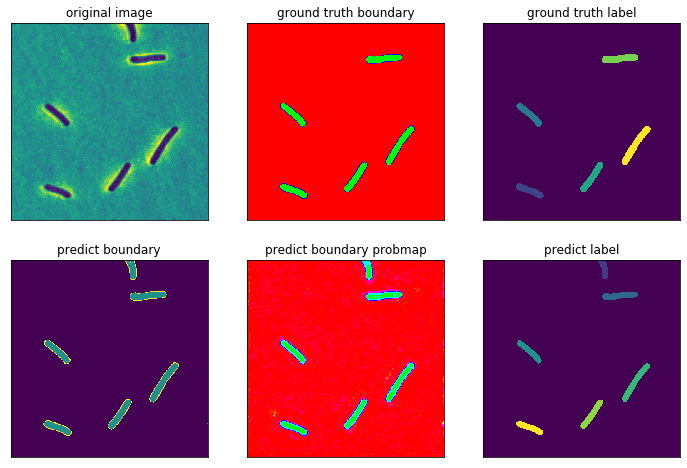

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/001.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/001.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


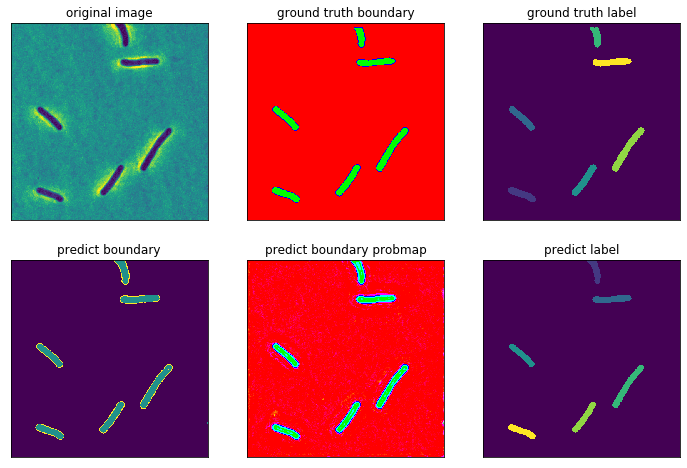

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/002.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/002.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


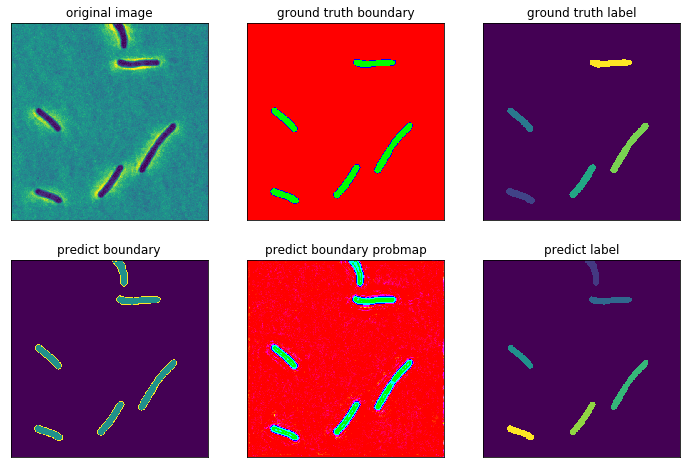

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/003.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/003.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


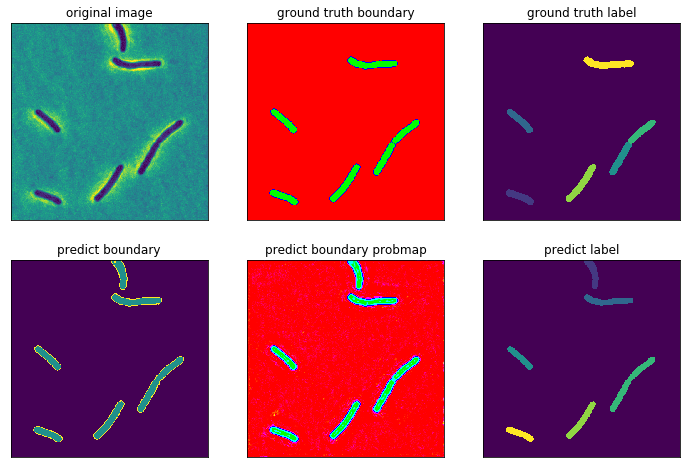

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/004.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/004.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


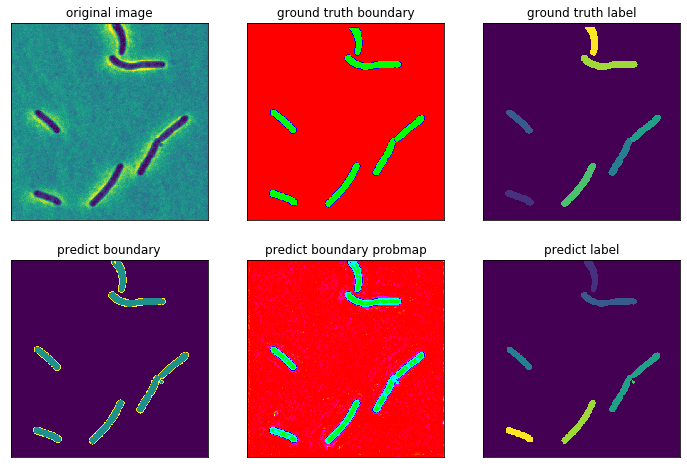

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/005.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


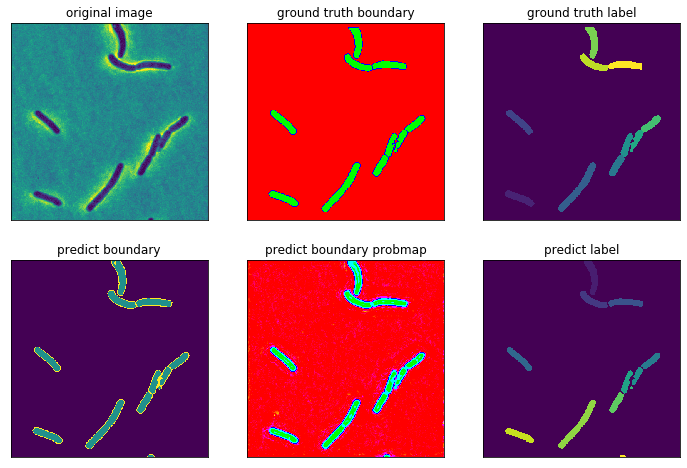

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/006.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/006.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


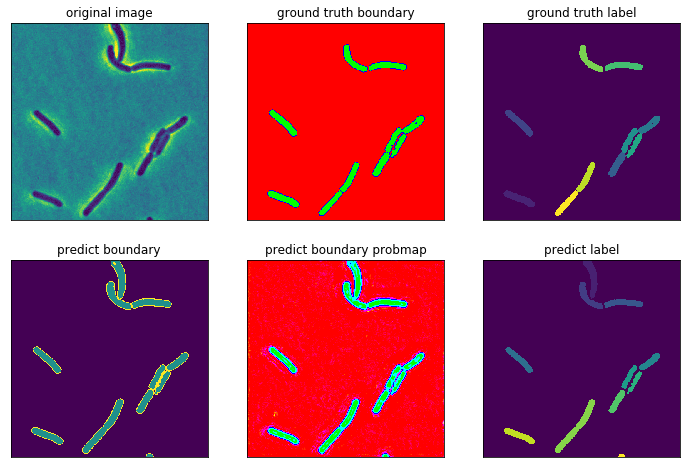

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/007.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//061/007.png is a low contrast image
  ],
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


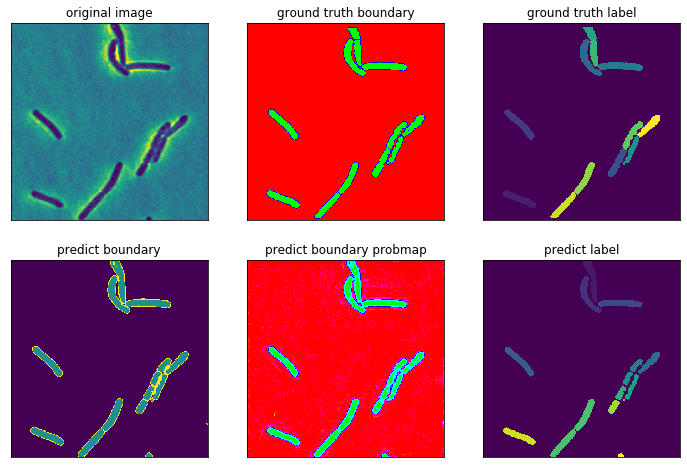

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/008.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


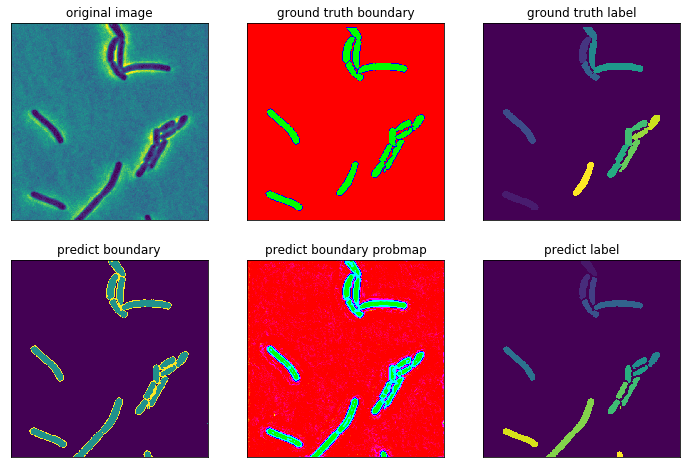

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/009.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


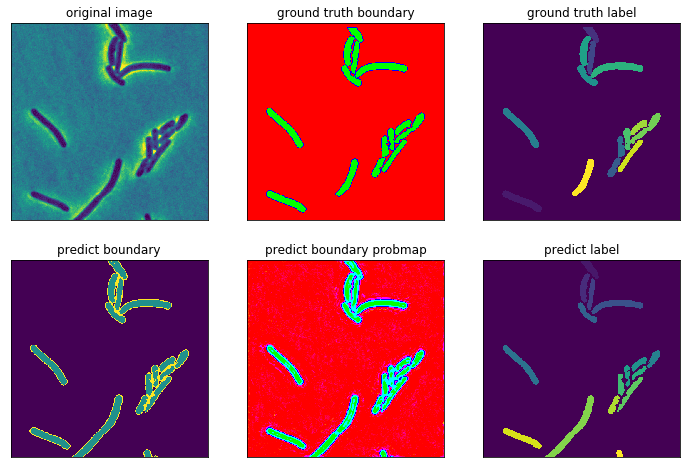

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/010.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


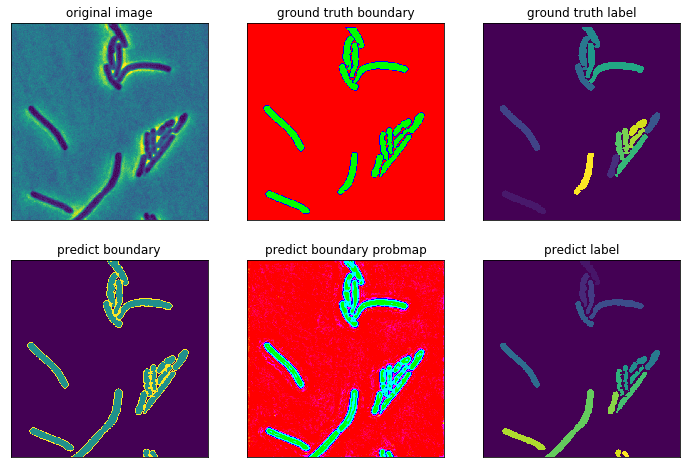

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/011.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


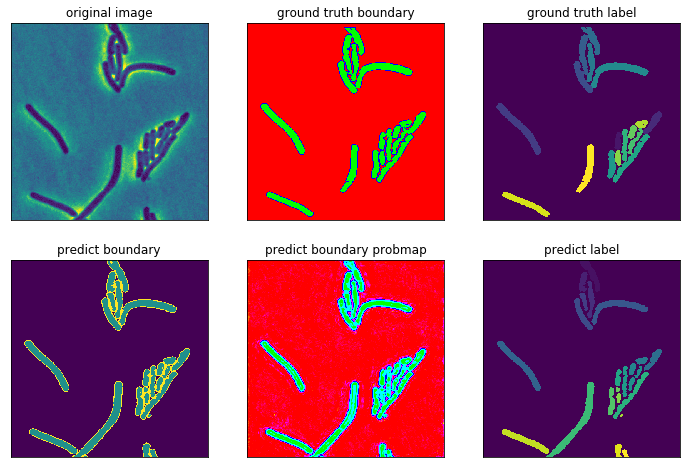

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/012.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


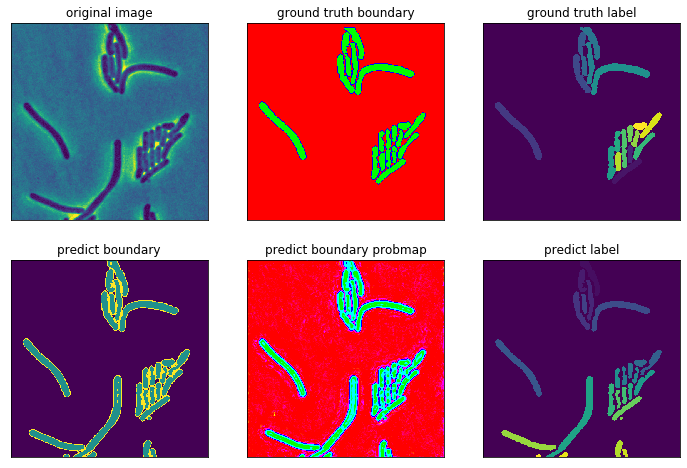

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/013.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


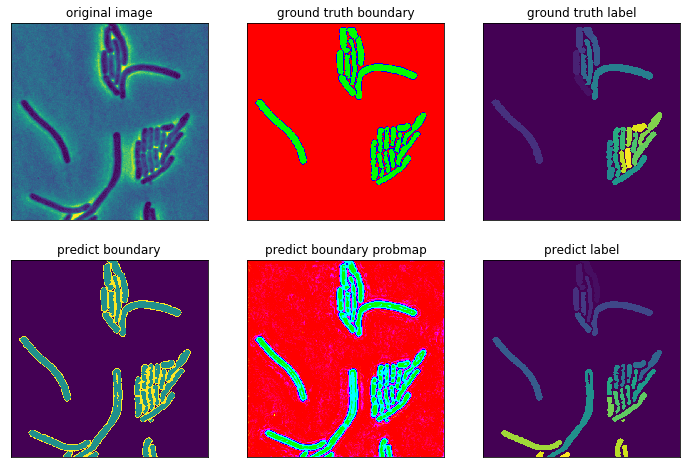

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/014.png is a low contrast image
  "output_type": "stream",
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


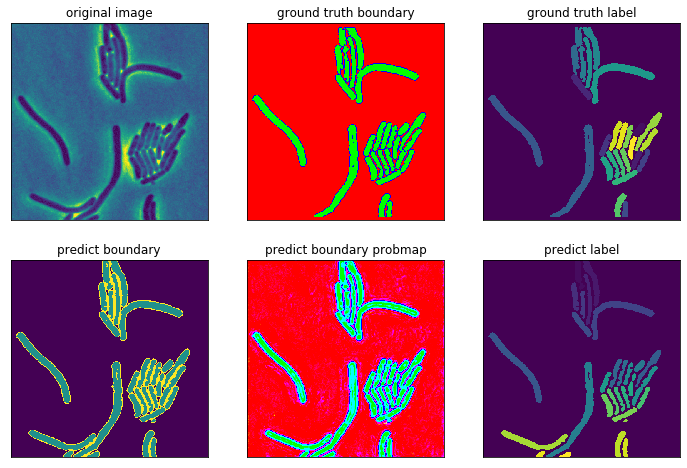

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/015.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/016.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/017.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/018.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/019.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//061/020.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ip

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//063/010.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//063/011.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//063/011.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//063/012.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//063/012.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//063/013.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experi

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/010.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/011.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/012.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/013.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/014.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//065/015.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ip

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//067/015.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//068/000.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//068/000.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//068/001.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//068/001.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//068/002.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//070/003.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//070/004.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//070/004.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//070/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//070/005.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//070/006.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experi

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/009.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/010.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/011.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/012.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/013.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//072/014.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ip

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//075/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//075/005.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//075/006.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//075/007.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//075/008.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//075/009.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//078/000.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//078/001.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//078/001.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//078/002.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//078/002.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//078/003.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experi

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//080/004.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//080/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//080/006.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//080/006.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//080/007.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//080/008.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//082/008.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//082/009.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//082/010.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//082/011.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//082/012.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//082/013.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//084/014.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//084/015.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//085/000.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//085/000.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//085/001.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//085/001.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//087/002.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//087/003.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//087/003.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//087/004.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//087/004.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//087/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experi

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/006.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/007.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/008.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/009.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//089/010.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ip

full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//091/014.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//091/015.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//092/000.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//092/000.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//092/001.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//092/001.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/

full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//094/002.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//094/003.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//094/003.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//094/004.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/segm//094/004.png is a low contrast image
  ],
full-exper-LT.ipynb:14: UserWarning: /home/seizethedty/DATA/LineageTracking/experiments/12/out/prob//094/005.png is a low contrast image
  "output_type": "stream",
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/experi

In [24]:
for i in range(len(images)):
    filename = imagebuffer.files[i]
#     imgname = os.path.basename(filename)
    filename_split = filename.split('/')
    imgname = '/' + filename_split[-2] + '/' + filename_split[-1]
#     print(filename, imgname)
    
    original_image = skimage.io.imread(filename)
    rl_image = skimage.io.imread(rl_buffer.files[i])
    bl_image = skimage.io.imread(bl_buffer.files[i])
    
    probmap = predictions[i].squeeze()
    os.makedirs(os.path.join(config_vars["probmap_out_dir"], filename_split[-2]), exist_ok=True)
    skimage.io.imsave(config_vars["probmap_out_dir"] + imgname, probmap.astype('uint8'))
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    os.makedirs(os.path.join(config_vars["labels_out_dir"], filename_split[-2]), exist_ok=True)
    skimage.io.imsave(config_vars["labels_out_dir"] + imgname, label.astype('uint8'))
    
    if (i < 15):
        f, ax = plt.subplots(2,3,figsize=(12,8))
        ax[0][0].imshow(original_image)
        ax[0][0].title.set_text('original image')
        ax[0][1].imshow(bl_image)
        ax[0][1].title.set_text('ground truth boundary')
        ax[0][2].imshow(rl_image)
        ax[0][2].title.set_text('ground truth label')
        ax[1][0].imshow(pred)
        ax[1][0].title.set_text('predict boundary')
        ax[1][1].imshow(probmap)
        ax[1][1].title.set_text('predict boundary probmap')
        ax[1][2].imshow(label)
        ax[1][2].title.set_text('predict label')
        for a in ax:
            for a_ in a:
                a_.set_xticks([])
                a_.set_yticks([])
        plt.show()
        
#     if (i == 15):
#         break


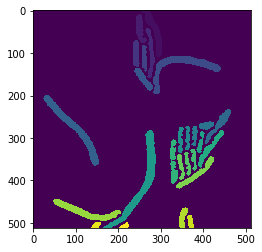

In [2]:
import skimage.io
from pylab import *
image = skimage.io.imread('/home/seizethedty/DATA/LineageTracking/experiments/08/out/segm//061/013.png')
imshow(image)

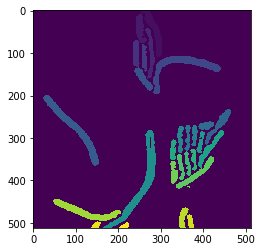

In [5]:
from pylab import *
example = skimage.io.imread('/home/seizethedty/DATA/LineageTracking/experiments/02/out/segm//061/013.png')
imshow(example)

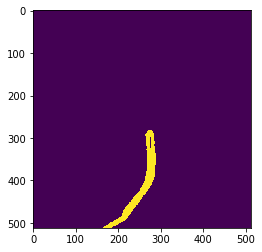

In [6]:
import numpy as np
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

Largest = getLargestCC(example)
imshow(Largest)

28

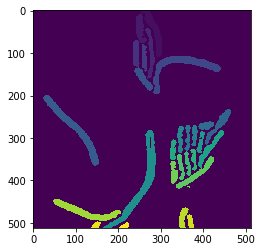

In [7]:
import numpy as np
from scipy.ndimage.measurements import label
structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
labeled, ncomponents = label(example, structure)

imshow(labeled)
ncomponents

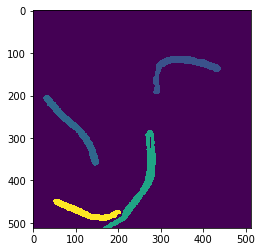

In [8]:
threshold = 2000
potential = np.copy(labeled)
for labels in range(1, ncomponents + 1):
    if np.count_nonzero(labeled == labels) >= threshold:
        continue
    for a in np.argwhere(labeled == labels):
        potential[a[0]][a[1]] = 0

imshow(potential)

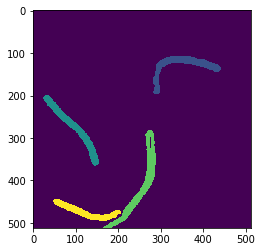

In [9]:
labeled_potential, ncomponents = label(potential, structure)
ncomponents
imshow(labeled_potential)

(473.20551779288286, 123.75009996001599)

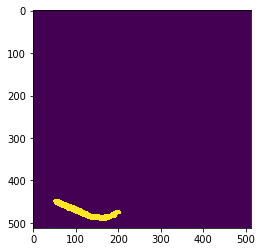

In [10]:
from scipy import ndimage

for labels in range(1, ncomponents + 1):
    aug = np.copy(labeled_potential)
    for a in np.argwhere(aug != labels):
        aug[a[0]][a[1]] = 0
    
imshow(aug)
ndimage.measurements.center_of_mass(aug)

In [2]:
from pylab import *
import numpy as np
from scipy.ndimage.measurements import label
from scipy import ndimage
from skimage.transform import resize

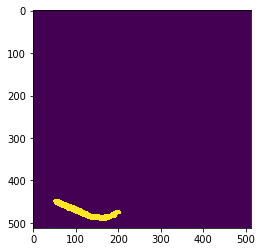

In [14]:
example = skimage.io.imread('/home/seizethedty/DATA/LineageTracking/experiments/02/out/segm//061/013.png')

structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
labeled, ncomponents = label(example, structure)

threshold = 2000
potential = np.copy(labeled)
for labels in range(1, ncomponents + 1):
    if np.count_nonzero(labeled == labels) >= threshold:
        continue
    for a in np.argwhere(labeled == labels):
        potential[a[0]][a[1]] = 0
        
labeled_potential, ncomponents = label(potential, structure)

for labels in range(1, ncomponents + 1):   ### not finished
    aug = np.copy(labeled_potential)
    for a in np.argwhere(aug != labels):
        aug[a[0]][a[1]] = 0
    
imshow(aug)
x, y = ndimage.measurements.center_of_mass(aug)

39


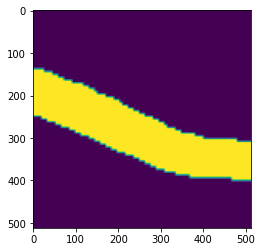

In [17]:
_x, _y = int(x), int(y)
size = min(512 - _x, 512 - _y, _x, _y)
print(size)
new_img = aug[_x - size:_x + size, _y - size:_y + size]
new_img_resize = resize(new_img, (512, 512))

imshow(new_img_resize)

count = 0

#skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_images/000/'+str(count)+'.tif', new_img_resize)  

473 123
(103, 128)


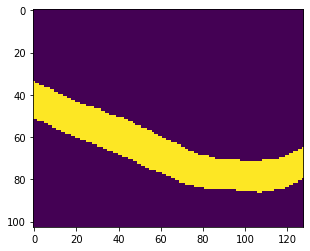

In [22]:
_x, _y = int(x), int(y)
#size = min(512 - _x, 512 - _y, _x, _y)
size = 64
new_img = aug[_x - size:_x + size, _y - size:_y + size]

print(_x , _y)
imshow(new_img)
print(np.shape(new_img))

In [79]:
a = '.png'

In [83]:
b = a[:-3] + 'tif'
b

'.tif'

In [12]:
import os
pred_list = sorted(os.listdir('/home/seizethedty/DATA/LineageTracking/experiments/02/out/segm/'))

In [13]:
# get these two lists for pre-process on all data
img_list = []
for f in pred_list:
    tmp_list = os.listdir('/home/seizethedty/DATA/LineageTracking/experiments/02/out/segm/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for img in sorted(tmp_list):
        img_list.append(f + '/' + img)

img_list

['061/000.png',
 '061/001.png',
 '061/002.png',
 '061/003.png',
 '061/004.png',
 '061/005.png',
 '061/006.png',
 '061/007.png',
 '061/008.png',
 '061/009.png',
 '061/010.png',
 '061/011.png',
 '061/012.png',
 '061/013.png',
 '061/014.png',
 '061/015.png',
 '061/016.png',
 '061/017.png',
 '061/018.png',
 '061/019.png',
 '061/020.png',
 '062/000.png',
 '062/001.png',
 '062/002.png',
 '062/003.png',
 '062/004.png',
 '062/005.png',
 '062/006.png',
 '062/007.png',
 '062/008.png',
 '062/009.png',
 '062/010.png',
 '062/011.png',
 '062/012.png',
 '062/013.png',
 '062/014.png',
 '062/015.png',
 '062/016.png',
 '062/017.png',
 '062/018.png',
 '062/019.png',
 '062/020.png',
 '063/000.png',
 '063/001.png',
 '063/002.png',
 '063/003.png',
 '063/004.png',
 '063/005.png',
 '063/006.png',
 '063/007.png',
 '063/008.png',
 '063/009.png',
 '063/010.png',
 '063/011.png',
 '063/012.png',
 '063/013.png',
 '063/014.png',
 '063/015.png',
 '063/016.png',
 '063/017.png',
 '063/018.png',
 '063/019.png',
 '063/02

In [14]:
# select potential regions and do data augmentation

filelist = img_list

def crop_img(filename, x, y, size, count):
    filename_raw = filename[:-3] + 'tif'   ### matters
    
    raw_img = skimage.io.imread(config_vars["raw_images_dir"] + filename_raw)  
    label_img = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)  
    
    new_raw_img = raw_img[x - size:x + size, y - size:y + size]
    #new_raw_img_resize = resize(new_raw_img, (512, 512))
    
    new_label_img = label_img[x - size:x + size, y - size:y + size]
    #new_label_img_resize = resize(new_label_img, (512, 512))
    
    if count <= 9:
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_images/000/' + '00' + str(count) + '.tif', new_raw_img)   
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_annotations/000/' + '00' + str(count) + '.png', new_label_img)   
    elif count<= 99:
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_images/000/' + '0' + str(count) + '.tif', new_raw_img)   
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_annotations/000/' + '0' + str(count) + '.png', new_label_img)
    else:
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_images/000/' + str(count) + '.tif', new_raw_img)   
        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/raw_annotations/000/' + str(count) + '.png', new_label_img)
        
def data_aug(filelist):
    count = 0
    for filename in tqdm(filelist):
        # load predicted image 
        predict_img = skimage.io.imread('/home/seizethedty/DATA/LineageTracking/experiments/02/out/segm/' + filename)       
        
        structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
        labeled, ncomponents = label(predict_img, structure)

        threshold = 3000
        potential = np.copy(labeled)
        for labels in range(1, ncomponents + 1):
            if np.count_nonzero(labeled == labels) >= threshold:
                continue
            for a in np.argwhere(labeled == labels):
                potential[a[0]][a[1]] = 0

        labeled_potential, ncomponents = label(potential, structure)

        for labels in range(1, ncomponents + 1):   ### not finished
            aug = np.copy(labeled_potential)
            for a in np.argwhere(aug != labels):
                aug[a[0]][a[1]] = 0
            
            x, y = ndimage.measurements.center_of_mass(aug)
            x, y = int(x), int(y)
            size = min(512 - x, 512 - y, x, y)
            if size < 64:
                continue
            size = 64
            crop_img(filename, x, y, size, count)
            count += 1
                   
data_aug(filelist)

  0%|          | 0/575 [00:00<?, ?it/s]full-exper-LT.ipynb:18: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/000.tif is a low contrast image
  }
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/000.png is a low contrast image
  ],
  1%|          | 5/575 [00:00<00:54, 10.44it/s]full-exper-LT.ipynb:18: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/001.tif is a low contrast image
  }
full-exper-LT.ipynb:19: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/001.png is a low contrast image
  ],
  1%|▏         | 8/575 [00:00<00:54, 10.33it/s]full-exper-LT.ipynb:18: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/002.tif is a low contrast image
  }
  2%|▏         | 9/575 [00:01<01:19,  7.08it/s]full-exper-LT.ipynb:18: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/003.tif is a low contrast image
  }
full-exper-LT.ipynb:19: UserWarning: /home/sei

  6%|▌         | 34/575 [00:12<03:12,  2.81it/s]full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/036.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/037.tif is a low contrast image
  "%load_ext autoreload\n",
  6%|▌         | 35/575 [00:13<04:07,  2.18it/s]full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/038.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/039.tif is a low contrast image
  "%load_ext autoreload\n",
  6%|▋         | 36/575 [00:14<04:51,  1.85it/s]full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/040.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/041.tif is

  9%|▉         | 54/575 [00:23<05:28,  1.59it/s]full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/070.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:22: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/070.png is a low contrast image
  "%autoreload 2\n",
full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/071.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:22: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/071.png is a low contrast image
  "%autoreload 2\n",
full-exper-LT.ipynb:21: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/072.tif is a low contrast image
  "%load_ext autoreload\n",
full-exper-LT.ipynb:22: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/072.png is a low contrast image
  "%autoreload 2\n",
 10%|▉         | 55/575 [00:24<05:44,  1.51it/s]full

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/114.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/115.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/116.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/117.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/118.tif is a low contrast image
  "\n",
 13%|█▎        | 76/575 [00:36<03:29,  2.38it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/119.tif is a low contrast image
  "\n",
 14%|█▎        | 78/575 [00:36<02:53,  2.87it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/120.tif is a low contrast i

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/157.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/158.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/159.tif is a low contrast image
  "\n",
 30%|███       | 174/575 [00:51<01:08,  5.86it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/160.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/160.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/161.tif is a low contrast image
  "\n",
 32%|███▏      | 186/575 [00:52<00:35, 10.81it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/162.tif is 

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/200.tif is a low contrast image
  "\n",
 38%|███▊      | 220/575 [01:02<03:51,  1.53it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/201.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/202.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/203.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/204.tif is a low contrast image
  "\n",
 38%|███▊      | 221/575 [01:03<04:19,  1.37it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/205.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/206.tif is a low contrast

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/249.tif is a low contrast image
  "\n",
 47%|████▋     | 268/575 [01:17<02:39,  1.92it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/250.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/251.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/252.tif is a low contrast image
  "\n",
 47%|████▋     | 269/575 [01:18<02:56,  1.74it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/253.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/253.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/254.tif is 

 55%|█████▌    | 317/575 [01:29<01:59,  2.15it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/291.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/291.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/292.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/292.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/293.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/294.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/294.png is a low contrast image
  "import

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/322.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/322.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/323.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/323.png is a low contrast image
  "import os\n",
 64%|██████▎   | 366/575 [01:39<01:02,  3.35it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/324.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/324.png is a low contrast image
  "import os\n",
 65%|██████▍   | 372/575 [01:39<00:42,  4.81it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTrackin

 69%|██████▊   | 394/575 [01:47<01:30,  1.99it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/356.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/357.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/357.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/358.tif is a low contrast image
  "\n",
 69%|██████▊   | 395/575 [01:47<01:41,  1.78it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/359.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/359.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/0

full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/391.tif is a low contrast image
  "\n",
 74%|███████▍  | 428/575 [01:56<01:05,  2.23it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/392.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/393.tif is a low contrast image
  "\n",
 75%|███████▍  | 429/575 [01:57<01:06,  2.19it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/394.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/394.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/395.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/395.pn

 80%|███████▉  | 459/575 [02:05<01:03,  1.83it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/424.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/425.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/426.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/427.tif is a low contrast image
  "\n",
 80%|████████  | 460/575 [02:06<01:19,  1.45it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/428.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/429.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/430.tif is a low contrast

 85%|████████▌ | 489/575 [02:20<00:35,  2.41it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/475.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/476.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/477.tif is a low contrast image
  "\n",
 85%|████████▌ | 491/575 [02:20<00:34,  2.43it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/478.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/479.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/480.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/481.tif is a low contrast

 94%|█████████▍| 540/575 [02:30<00:09,  3.51it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/513.tif is a low contrast image
  "\n",
 94%|█████████▍| 541/575 [02:31<00:09,  3.61it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/514.tif is a low contrast image
  "\n",
 94%|█████████▍| 542/575 [02:31<00:09,  3.61it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/515.tif is a low contrast image
  "\n",
 95%|█████████▌| 548/575 [02:31<00:05,  4.92it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/516.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/516.png is a low contrast image
  "import os\n",
 96%|█████████▌| 550/575 [02:32<00:06,  4.12it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images

100%|█████████▉| 573/575 [02:41<00:00,  2.56it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/544.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/544.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/545.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/545.png is a low contrast image
  "import os\n",
100%|█████████▉| 574/575 [02:41<00:00,  2.23it/s]full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_images/000/546.tif is a low contrast image
  "\n",
full-exper-LT.ipynb:25: UserWarning: /home/seizethedty/DATA/LineageTracking/raw_annotations/000/546.png is a low contrast image
  "import os\n",
full-exper-LT.ipynb:24: UserWarning: /home/seizethedty/DATA/LineageTrackin

In [15]:
# normalize images

img_list = []
tmp_list = os.listdir(config_vars["raw_images_dir"] + '000')
tmp_list = [x for x in tmp_list if x.endswith('tif')]
for img in sorted(tmp_list):
    img_list.append('000' + '/' + img)

list_norm = img_list  

def normalize_original_img(list_norm):
    for filename in tqdm(list_norm):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave('/home/seizethedty/DATA/LineageTracking/norm_images/' + filename[:-3] + 'png', img)   
        
normalize_original_img(list_norm)

100%|██████████| 548/548 [00:02<00:00, 272.08it/s]


In [16]:
# segmentation to boundary

img_list = []
tmp_list = os.listdir(config_vars["raw_annotations_dir"] + '000')
tmp_list = [x for x in tmp_list if x.endswith('png')]
for img in sorted(tmp_list):
    img_list.append('000' + '/' + img)

list_label = img_list 

def segment_to_label(list_label, total_objects = 0):
    for filename in tqdm(list_label):
        annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
        annot = skimage.morphology.label(annot)
        total_objects += len(np.unique(annot)) - 1
        annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
        # find boundaries
        boundaries = skimage.segmentation.find_boundaries(annot)
        for k in range(2, config_vars["boundary_size"], 2):
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # 3-CHANNEL BINARY LABEL
        # prepare buffer for binary label
        label_binary = np.zeros((annot.shape + (3,))) 
        label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
        label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
        label_binary[boundaries == 1, 2] = 1  # boundary
        # Convert an image to unsigned byte format, with values in [0, 255]
        label_binary = skimage.img_as_ubyte(label_binary)
        skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    print("Total objects: ",total_objects)
    
segment_to_label(list_label)

  0%|          | 0/548 [00:00<?, ?it/s]full-exper-LT.ipynb:16: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  "Using TensorFlow backend.\n"
full-exper-LT.ipynb:30: UserWarning: /home/seizethedty/DATA/LineageTracking/boundary_labels/000/009.png is a low contrast image
  "import numpy as np\n",
  2%|▏         | 10/548 [00:00<00:05, 97.55it/s]full-exper-LT.ipynb:30: UserWarning: /home/seizethedty/DATA/LineageTracking/boundary_labels/000/012.png is a low contrast image
  "import numpy as np\n",
full-exper-LT.ipynb:30: UserWarning: /home/seizethedty/DATA/LineageTracking/boundary_labels/000/017.png is a low contrast image
  "import numpy as np\n",
full-exper-LT.ipynb:30: UserWarning: /home/seizethedty/DATA/LineageTracking/boundary_labels/000/020.png is a low contrast image
  "import numpy as np\n",
  4%|▍         | 22/548 [00:00<00:05, 100.79it/s]full-exper-LT.ipynb:30: UserWarning: /home/seizethedty/DATA/LineageTracking/boundary_la

Total objects:  2317
